# Analyzing Financial Statements I

We analyze this [dataset](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html). Because this dataset is quite large (from 8GB up to ~90GB), below we use an extract of the dataset that focuses on [Apple](http://investor.apple.com/).

An example of a filing is [here](http://files.shareholder.com/downloads/AAPL/6110044160x0x979058/B67C9B87-ED0A-4551-B1E1-E95249A2B1A2/10-Q_Q2_2018_As-Filed_.pdf).

## Setup

Some initialization to make life easier. **Make sure to run the following cell before proceeding.**

In [1]:
#Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#Show simple plots in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

We use the following libraries:
* [Pandas](https://pandas.pydata.org) is the most important workhorse in data analytics.
* [Altair](https://altair-viz.github.io) is a visualization library.

In [2]:
import pandas as pd
import altair as alt
from altair import *
import numpy as np
#Show up to 500 rows
pd.set_option('display.max_rows', 500)
#Format number without four decimals
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#Show altair plots in the notebook
alt.renderers.enable('notebook')

## Extract data

For your reference, the following function extracts the data across the zip-files that the SEC [provides](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html).

In [3]:
import os
import re

def extract_fs_info(filename, adsh=None, ending='.tsv', topdir = './'):
    dataframe = pd.DataFrame()
    for dirpath, dirnames, files in os.walk(topdir):
        for name in files:
            if (name.lower().endswith(ending)) & (name.startswith(filename)):
                print(dirpath)
                fs_period = re.search('\./(\d+)q(\d?)', dirpath)
                fs_year = fs_period.group(1)
                fs_quarter = fs_period.group(2)
                s = pd.read_csv(os.path.join(dirpath, name), sep='\t', low_memory=False, encoding = "ISO-8859-1")
                if adsh is not None:
                   s = s[s['adsh'].isin(adsh)].copy()
                s['fs_year'], s['fs_quarter'] = fs_year,fs_quarter 
                dataframe = dataframe.append(s)
    return dataframe

In [4]:
#sub = extract_fs_info('sub', ending='.txt')
#num = extract_fs_info('num', adsh=apple['adsh'], ending='.txt')
#pre = extract_fs_info('pre', adsh=apple['adsh'], ending='.txt')

## The SUB file

The `SUB` file contains the individual filings that have been **sub**mitted to the SEC. Here, we load Apple's filings since 2010 (including).

In [5]:
sub = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/apple_sub.csv')

In [6]:
sub.columns

Index(['adsh', 'cik', 'name', 'sic', 'countryba', 'stprba', 'cityba', 'zipba',
       'bas1', 'bas2', 'baph', 'countryma', 'stprma', 'cityma', 'zipma',
       'mas1', 'mas2', 'countryinc', 'stprinc', 'ein', 'former', 'changed',
       'afs', 'wksi', 'fye', 'form', 'period', 'fy', 'fp', 'filed', 'accepted',
       'prevrpt', 'detail', 'instance', 'nciks', 'aciks', 'fs_year',
       'fs_quarter'],
      dtype='object')

The following columns are important for the following analysis:

| Column | Description (Source: [SEC](https://www.sec.gov/files/aqfsn_1.pdf))|
| -------- |:-------------:|
|adsh|  A unique identifier assigned automatically to an accepted submission by the EDGAR Filer System. The identifier has the format `CIK - Year - Count`. |
|cik |  A unique numerical identifier assigned by the EDGAR system to filers. |
|name| Name of filer. This corresponds to the name of the legal entity as recorded in EDGAR as of the filing date.|
|sic| Name of registrant. This corresponds to the name of the legal entity as recorded in EDGAR as of the filing date.|
|fye| Fiscal Year End Date with the format (MMDD).|
|form| The submission type of the registrant's filing.|
|period| Balance Sheet Date with the format (YYMMDD).|
|fy| Fiscal Year Focus with the format (YYYY). |
|pf| Fiscal Period Focus (10-Q form is for the quarters Q1,Q2, and Q3, 10-K form is for FY)|
|fs_year| Year from folder name |
|fs_quarter| Quarter from the folder name|

In [7]:
sub = sub.loc[:,['adsh', 'cik', 'name', 'sic', 'fye', 'form', 'period', 'fy', 'fp', 'fs_year', 'fs_quarter']]

In [8]:
sub.head()

,adsh,cik,name,sic,fye,form,period,fy,fp,fs_year,fs_quarter
0,0001193125-10-012085,320193,APPLE INC,3571,930,10-Q,20091231,2010,Q1,2010,1
1,0001193125-10-012091,320193,APPLE INC,3571,930,10-K/A,20090930,2009,FY,2010,1
2,0001193125-10-088957,320193,APPLE INC,3571,930,10-Q,20100331,2010,Q2,2010,2
3,0001193125-10-162840,320193,APPLE INC,3571,930,10-Q,20100630,2010,Q3,2010,3
4,0001193125-10-238044,320193,APPLE INC,3571,930,10-K,20100930,2010,FY,2010,4


## The NUM file

The `NUM` file contains "includes one row for each distinct amount from each submission
included in the SUB data set." (Source: [SEC](https://www.sec.gov/files/aqfsn_1.pdf))

In [9]:
num = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/apple_num.csv')

In [10]:
num.columns

Index(['adsh', 'tag', 'version', 'coreg', 'ddate', 'qtrs', 'uom', 'value',
       'footnote', 'fs_year', 'fs_quarter'],
      dtype='object')

The following columns are important for the following analysis:

| Column | Description (Source: [SEC](https://www.sec.gov/files/aqfsn_1.pdf)) |
| -------- |:-------------:|
|adsh| "A unique identifier assigned automatically to an accepted submission by the EDGAR Filer System." The identifier has the format `CIK - Year - Count`. |
|tag | "The unique identifier (name) for a tag in a specific taxonomy release." |
|version| "For a standard tag, an identifier for the taxonomy; otherwise the accession number where the tag was defined." |
|ddate | "The end date for the data value, rounded to the nearest month end."|
|qtrs | "The count of the number of quarters represented by the data value, rounded to the nearest whole number. "0" indicates it is a point-in-time value.|
|uom| "The unit of measure for the value."|
|value| "The value. This is rounded to four digits to the right of the decimal point."|
|footnote| "The plain text of any superscripted footnotes on the value, if any, as shown on the statement page, truncated to 512 characters."|
|fs_year| Year from folder name |
|fs_quarter| Quarter from the folder name|

In [11]:
num.head()

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,fs_year,fs_quarter
0,0001193125-14-277160,AccountsPayableCurrent,us-gaap/2014,nan,20130930,0,USD,22367000000.0000,NaN,2014,3
1,0001193125-14-277160,AccountsPayableCurrent,us-gaap/2014,nan,20140630,0,USD,20535000000.0000,NaN,2014,3
2,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20130930,0,USD,13102000000.0000,NaN,2014,3
3,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20140630,0,USD,10788000000.0000,NaN,2014,3
4,0001193125-14-277160,AccruedLiabilitiesCurrent,us-gaap/2014,nan,20130930,0,USD,13856000000.0000,NaN,2014,3


## The PRE file

The `PRE` file "provides information about how the tags and numbers were
presented in the primary financial statements." (Source: [SEC](https://www.sec.gov/files/aqfsn_1.pdf))

In [12]:
pre = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/apple_pre.csv')

In [13]:
pre.columns

Index(['adsh', 'report', 'line', 'stmt', 'inpth', 'rfile', 'tag', 'version',
       'plabel', 'negating', 'fs_year', 'fs_quarter'],
      dtype='object')

The following columns are important for the following analysis:

| Column | Description (Source: [SEC](https://www.sec.gov/files/aqfsn_1.pdf))|
| -------- |:-------------:|
|adsh| "A unique identifier assigned automatically to an accepted submission by the EDGAR Filer System." The identifier has the format `CIK - Year - Count`. |
|report| "Represents the report grouping."
|line | "Represents the tag's presentation line order for a given report." |
|stmt | "The financial statement location to which the value of the "report" field pertains. (CP = Cover Page, BS = Balance Sheet, IS = Income Statement, CF = Cash Flow, EQ = Equity, CI = C omprehensive Income, UN = Unclassifiable Statement) |
| tag | "The tag chosen by the filer for this line item."|
| version | "The taxonomy identifier if the tag is a standard tag, otherwise adsh.|
|fs_year| Year from folder name |
|fs_quarter| Quarter from the folder name|

In [14]:
pre = pre.loc[:,['adsh', 'report', 'line', 'stmt', 'tag', 'version', 'fs_year', 'fs_quarter']]

In [15]:
pre.head()

,adsh,report,line,stmt,tag,version,fs_year,fs_quarter
0,0001193125-14-277160,4,21,BS,AccountsPayableCurrent,us-gaap/2014,2014,3
1,0001193125-14-277160,4,7,BS,AccountsReceivableNetCurrent,us-gaap/2014,2014,3
2,0001193125-14-277160,4,22,BS,AccruedLiabilitiesCurrent,us-gaap/2014,2014,3
3,0001193125-14-277160,6,6,CF,AdjustmentsToReconcileNetIncomeLossToCashProvi...,us-gaap/2014,2014,3
4,0001193125-14-277160,5,3,BS,AllowanceForDoubtfulAccountsReceivableCurrent,us-gaap/2014,2014,3


## Prepare the analysis

We begin with filtering the important reports. Let's assume we are only interested in 10-Q and 10-K.

In [16]:
sub = sub[sub['form'].isin(['10-Q','10-K'])]

In [17]:
len(sub)

33

We have 33 financial statements:
* four statements for each year in the timeframe of 2010 to 2017
* one statement for the first quarter of 2018

Similarly, we filter the `NUM` and the `PRE` files to contain only the filings of interest.

In [18]:
num = num[num['adsh'].isin(sub['adsh'])]
pre = pre[pre['adsh'].isin(sub['adsh'])]

Apple's financial years ends on September, 30 ([Apple](https://www.apple.com/newsroom/2017/11/apple-reports-fourth-quarter-results/)). This means that:
* Q1 - October, 1 to December, 31.
* Q2 - January, 1 to March, 31.
* Q3 - April, 1 to June, 30.
* Q4 - July, 1 to September, 30.

The reporting period is stated in the `SUB` file. We merge the relevant column `period` to the `NUM` file.

In [19]:
num = pd.merge(num, sub[['adsh', 'period']], how='left', on='adsh')

We add Apple's financial quarter to the dataset.

In [20]:
num['fin_quarter'] = pd.PeriodIndex(num['ddate'], freq='Q-SEP')

In [21]:
num.head()

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,fs_year,fs_quarter,period,fin_quarter
0,0001193125-14-277160,AccountsPayableCurrent,us-gaap/2014,nan,20130930,0,USD,22367000000.0000,NaN,2014,3,20140630,2013Q4
1,0001193125-14-277160,AccountsPayableCurrent,us-gaap/2014,nan,20140630,0,USD,20535000000.0000,NaN,2014,3,20140630,2014Q3
2,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20130930,0,USD,13102000000.0000,NaN,2014,3,20140630,2013Q4
3,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20140630,0,USD,10788000000.0000,NaN,2014,3,20140630,2014Q3
4,0001193125-14-277160,AccruedLiabilitiesCurrent,us-gaap/2014,nan,20130930,0,USD,13856000000.0000,NaN,2014,3,20140630,2013Q4


A financial statement typically contains a comparison period to shows the performance of the company. Since we analyze multiple periods, we do not need the comparison values. We need to filter the comparison values. 

In [22]:
num = num[num['ddate']==num['period']]

In [23]:
num.head()

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,fs_year,fs_quarter,period,fin_quarter
1,0001193125-14-277160,AccountsPayableCurrent,us-gaap/2014,nan,20140630,0,USD,20535000000.0000,NaN,2014,3,20140630,2014Q3
3,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20140630,0,USD,10788000000.0000,NaN,2014,3,20140630,2014Q3
5,0001193125-14-277160,AccruedLiabilitiesCurrent,us-gaap/2014,nan,20140630,0,USD,15264000000.0000,NaN,2014,3,20140630,2014Q3
7,0001193125-14-277160,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2014,nan,20140630,0,USD,16868000000.0000,NaN,2014,3,20140630,2014Q3
8,0001193125-14-277160,AllowanceForDoubtfulAccountsReceivableCurrent,us-gaap/2014,nan,20140630,0,USD,86000000.0000,NaN,2014,3,20140630,2014Q3


We want to use the financial quarter on the x-Axis of our visualizations. However, currently, `fin_quarter` is a TimePeriod object, which cannot be used for this purpose. Thus, we have to transform it into a string.

In [24]:
num['fin_quarter_viz'] = num['fin_quarter'].dt.strftime('%F-Q%q')

## A first look at the data

In [25]:
ar = num[num['tag'].str.contains('AccountsReceivableNetCurrent')].copy()

In [26]:
ar.head()

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,fs_year,fs_quarter,period,fin_quarter,fin_quarter_viz
3,0001193125-14-277160,AccountsReceivableNetCurrent,us-gaap/2014,nan,20140630,0,USD,10788000000.0000,NaN,2014,3,20140630,2014Q3,2014-Q3
407,0001193125-14-383437,AccountsReceivableNetCurrent,us-gaap/2014,nan,20140930,0,USD,17460000000.0000,NaN,2014,4,20140930,2014Q4,2014-Q4
1015,0000320193-18-000007,AccountsReceivableNetCurrent,us-gaap/2017,nan,20171231,0,USD,23440000000.0000,NaN,2018,1,20171231,2018Q1,2018-Q1
1305,0001193125-10-088957,AccountsReceivableNetCurrent,us-gaap/2009,nan,20100331,0,USD,2886000000.0000,NaN,2010,2,20100331,2010Q2,2010-Q2
1481,0001193125-12-023398,AccountsReceivableNetCurrent,us-gaap/2011,nan,20111231,0,USD,8930000000.0000,NaN,2012,1,20111231,2012Q1,2012-Q1


It is important to understand that Accounts Receivable represents a value at given point in time. This is represented by the field `qtrs`. A `0` means that it is a value for a given point in time. Any value larger than `0` refers to the number of quarters. 

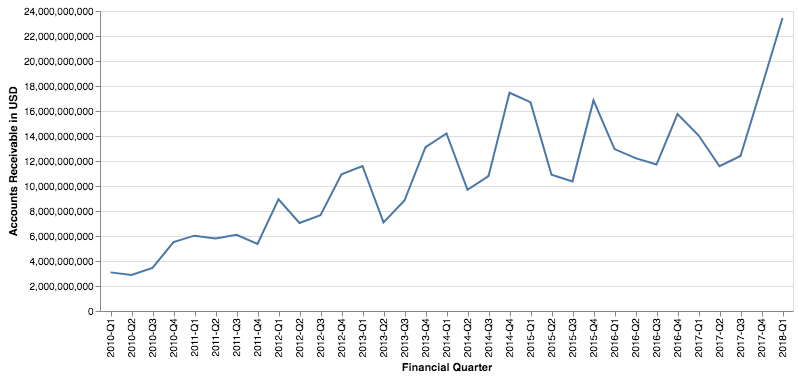

In [27]:
ar_chart = alt.Chart(ar.loc[:,['value', 'fin_quarter_viz']]).mark_line().encode(
    x=alt.X('fin_quarter_viz', axis=alt.Axis(title='Financial Quarter')),
    y=alt.Y('value', axis=alt.Axis(title='Accounts Receivable in USD')),
)
ar_chart

The sales revenue refers to a quarter. Thus, we have to filter for the quarterly value (`qtrs` = `1`)

In [28]:
sales = num[(num['tag'].str.contains('SalesRevenueNet')) & (num['qtrs']==1)].copy()

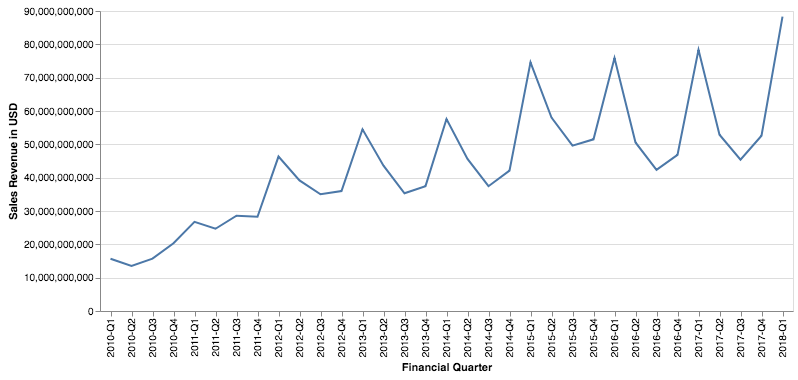

In [29]:
sales_chart = alt.Chart(sales.loc[:,['value', 'fin_quarter_viz']]).mark_line().encode(
    x=alt.X('fin_quarter_viz', axis=alt.Axis(title='Financial Quarter')),
    y=alt.Y('value', axis=alt.Axis(title='Sales Revenue in USD')),
)
sales_chart

In [30]:
gp = num[(num['tag'].str.contains('GrossProfit')) & (num['qtrs']==1)].copy()

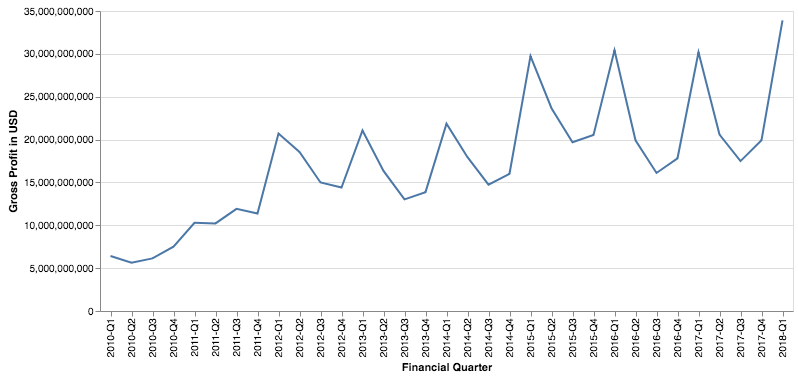

In [31]:
gp_chart = alt.Chart(gp.loc[:,['value', 'fin_quarter_viz']]).mark_line().encode(
    x=alt.X('fin_quarter_viz', axis=alt.Axis(title='Financial Quarter')),
    y=alt.Y('value', axis=alt.Axis(title='Gross Profit in USD')),
)
gp_chart

## Receivables Turnover Ratio

We calculate the quarterly [receivables turnover ratio](https://en.wikipedia.org/wiki/Receivables_turnover_ratio) as follows:
\begin{equation*}
Quarterly \ Receivables \ Turnover \ Ratio = \frac{Quarterly \ Sales \ Revenue}{\Bigl(\frac{Accounts \ Receivables_{Previous \ Quarter} + Accounts \ Receivables_{Current \ Quarter}}{2})}
\end{equation*}

In [32]:
rtr = pd.merge(ar.loc[:, ['adsh', 'tag', 'value', 'fin_quarter_viz']], \
               sales.loc[:, ['adsh', 'tag', 'value', 'fin_quarter_viz']], \
               how='left', on=['adsh', 'fin_quarter_viz'], \
               suffixes=('_ar', '_sales')).sort_values('fin_quarter_viz')

In [33]:
rtr['avg_ar'] = (rtr['value_ar'] + rtr['value_ar'].shift(1))/2

In [34]:
rtr['ar_turnover'] = rtr['value_sales']/rtr['avg_ar']

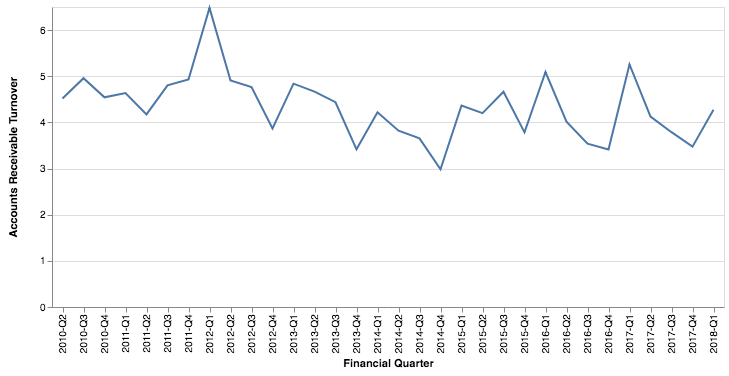

In [35]:
rtr_chart = alt.Chart(rtr.loc[:,['ar_turnover', 'fin_quarter_viz']]).mark_line().encode(
    x=alt.X('fin_quarter_viz', axis=alt.Axis(title='Financial Quarter')),
    y=alt.Y('ar_turnover', axis=alt.Axis(title='Accounts Receivable Turnover')),
)
rtr_chart